# concanate data 

In [ ]:
## load data and funtions 
#########################################################################################
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess, behaviorAnalysis, get_noisyICs
with open(os.path.join( workspace_root,'Data', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)

with open(os.path.join( workspace_root, 'Data', 'bad_channels_detected.pkl'), "rb") as f:
    all_bads = pickle.load(f)


def pre_cncat(id):
    bads_channel= all_bads[id]['channel_names']
    bad_trials= all_bads[id]['trial_numbers']
    blink_components = all_bads[id]['ica_blinks']
    bridged_channels= all_bridged_channels[5][id] 
    sub = preprocess(id)
    raw = sub.load_data()
    #############################################################################################
    # 1. remove noisy channels
    raw.info['bads'] = bads_channel
    # 2. Filter the data
    raw.notch_filter([50,100], fir_design='firwin', skip_by_annotation='edge')
    raw.filter(l_freq=1, h_freq= None)
    # 3. segment the data from stim to response (remove noisy trials and trials with wrong answers)
    events = mne.find_events(raw)
    all_events = sub.get_all_events_times(id, events).dropna()
    new_raw = sub.segment_stimRt(raw, all_events, bad_trials)
    # 4. remove blink components 
    ica_path = os.path.join(workspace_root, 'Data', f'S{id}_ica_infomax.fif')
    ica = mne.preprocessing.read_ica(ica_path)
    noisy_components = get_noisyICs( new_raw,ica, threshold=0.7, noise_type = None)
    ica.exclude = noisy_components
    ica.apply(new_raw)
    # 5. interpolate bridged channels
    new_raw = mne.preprocessing.interpolate_bridged_electrodes(new_raw, bridged_channels['bridged_idx'], bad_limit=3) 
    # 6. interpolate bad channels
    new_raw.interpolate_bads()
    # 7. rereference the data
    new_raw.set_eeg_reference(ref_channels='average')
    # 8. zscore the data
    data = new_raw.get_data()
    chan_means = np.mean(data, axis=1, keepdims=True)
    chan_stds  = np.std(data,  axis=1, keepdims=True)
    zscored_data = (data - chan_means) / chan_stds
    new_raw._data = zscored_data
    return new_raw



In [2]:
all_bads

{601: {'channel_names': ['D29', 'B27'],
  'trial_numbers': [57, 58, 59, 55, 106],
  'ica_blinks': [0, 5]},
 602: {'channel_names': ['A32'],
  'trial_numbers': [19, 17, 20, 62, 69, 71, 75, 77, 78, 92, 86, 80, 107],
  'ica_blinks': [0, 5]},
 603: {'channel_names': [], 'trial_numbers': [1, 102, 49], 'ica_blinks': [0]},
 604: {'channel_names': ['A31'], 'trial_numbers': [], 'ica_blinks': [0, 1]},
 605: {'channel_names': [],
  'trial_numbers': [55, 6, 19, 20, 21],
  'ica_blinks': [0, 8]},
 606: {'channel_names': [], 'trial_numbers': [], 'ica_blinks': [0]}}

In [ ]:
ids = [601,602,603,604,605,606]
all_pregICA = []
for id in ids:
    pregICA = pre_cncat(id)
    all_pregICA.append(pregICA)
combined_pregICA = mne.concatenate_raws(all_pregICA)
# 9. save the data
combined_pregICA_path = os.path.join(workspace_root, 'Data', 'combined_pregICA_noLF.fif')
combined_pregICA.save(combined_pregICA_path, overwrite=True)

Opening raw data file c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif...


    Range : 2835 ... 768746 =      5.537 ...  1501.457 secs
Ready.
Reading 0 ... 765911  =      0.000 ...  1495.920 secs...


C:\Users\gmoha\AppData\Local\Temp\ipykernel_9436\3386219552.py:2: RuntimeWarning: This filename (c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  combined_pregICA = mne.io.read_raw_fif(combined_pregICA_path, preload=True)


Using matplotlib as 2D backend.


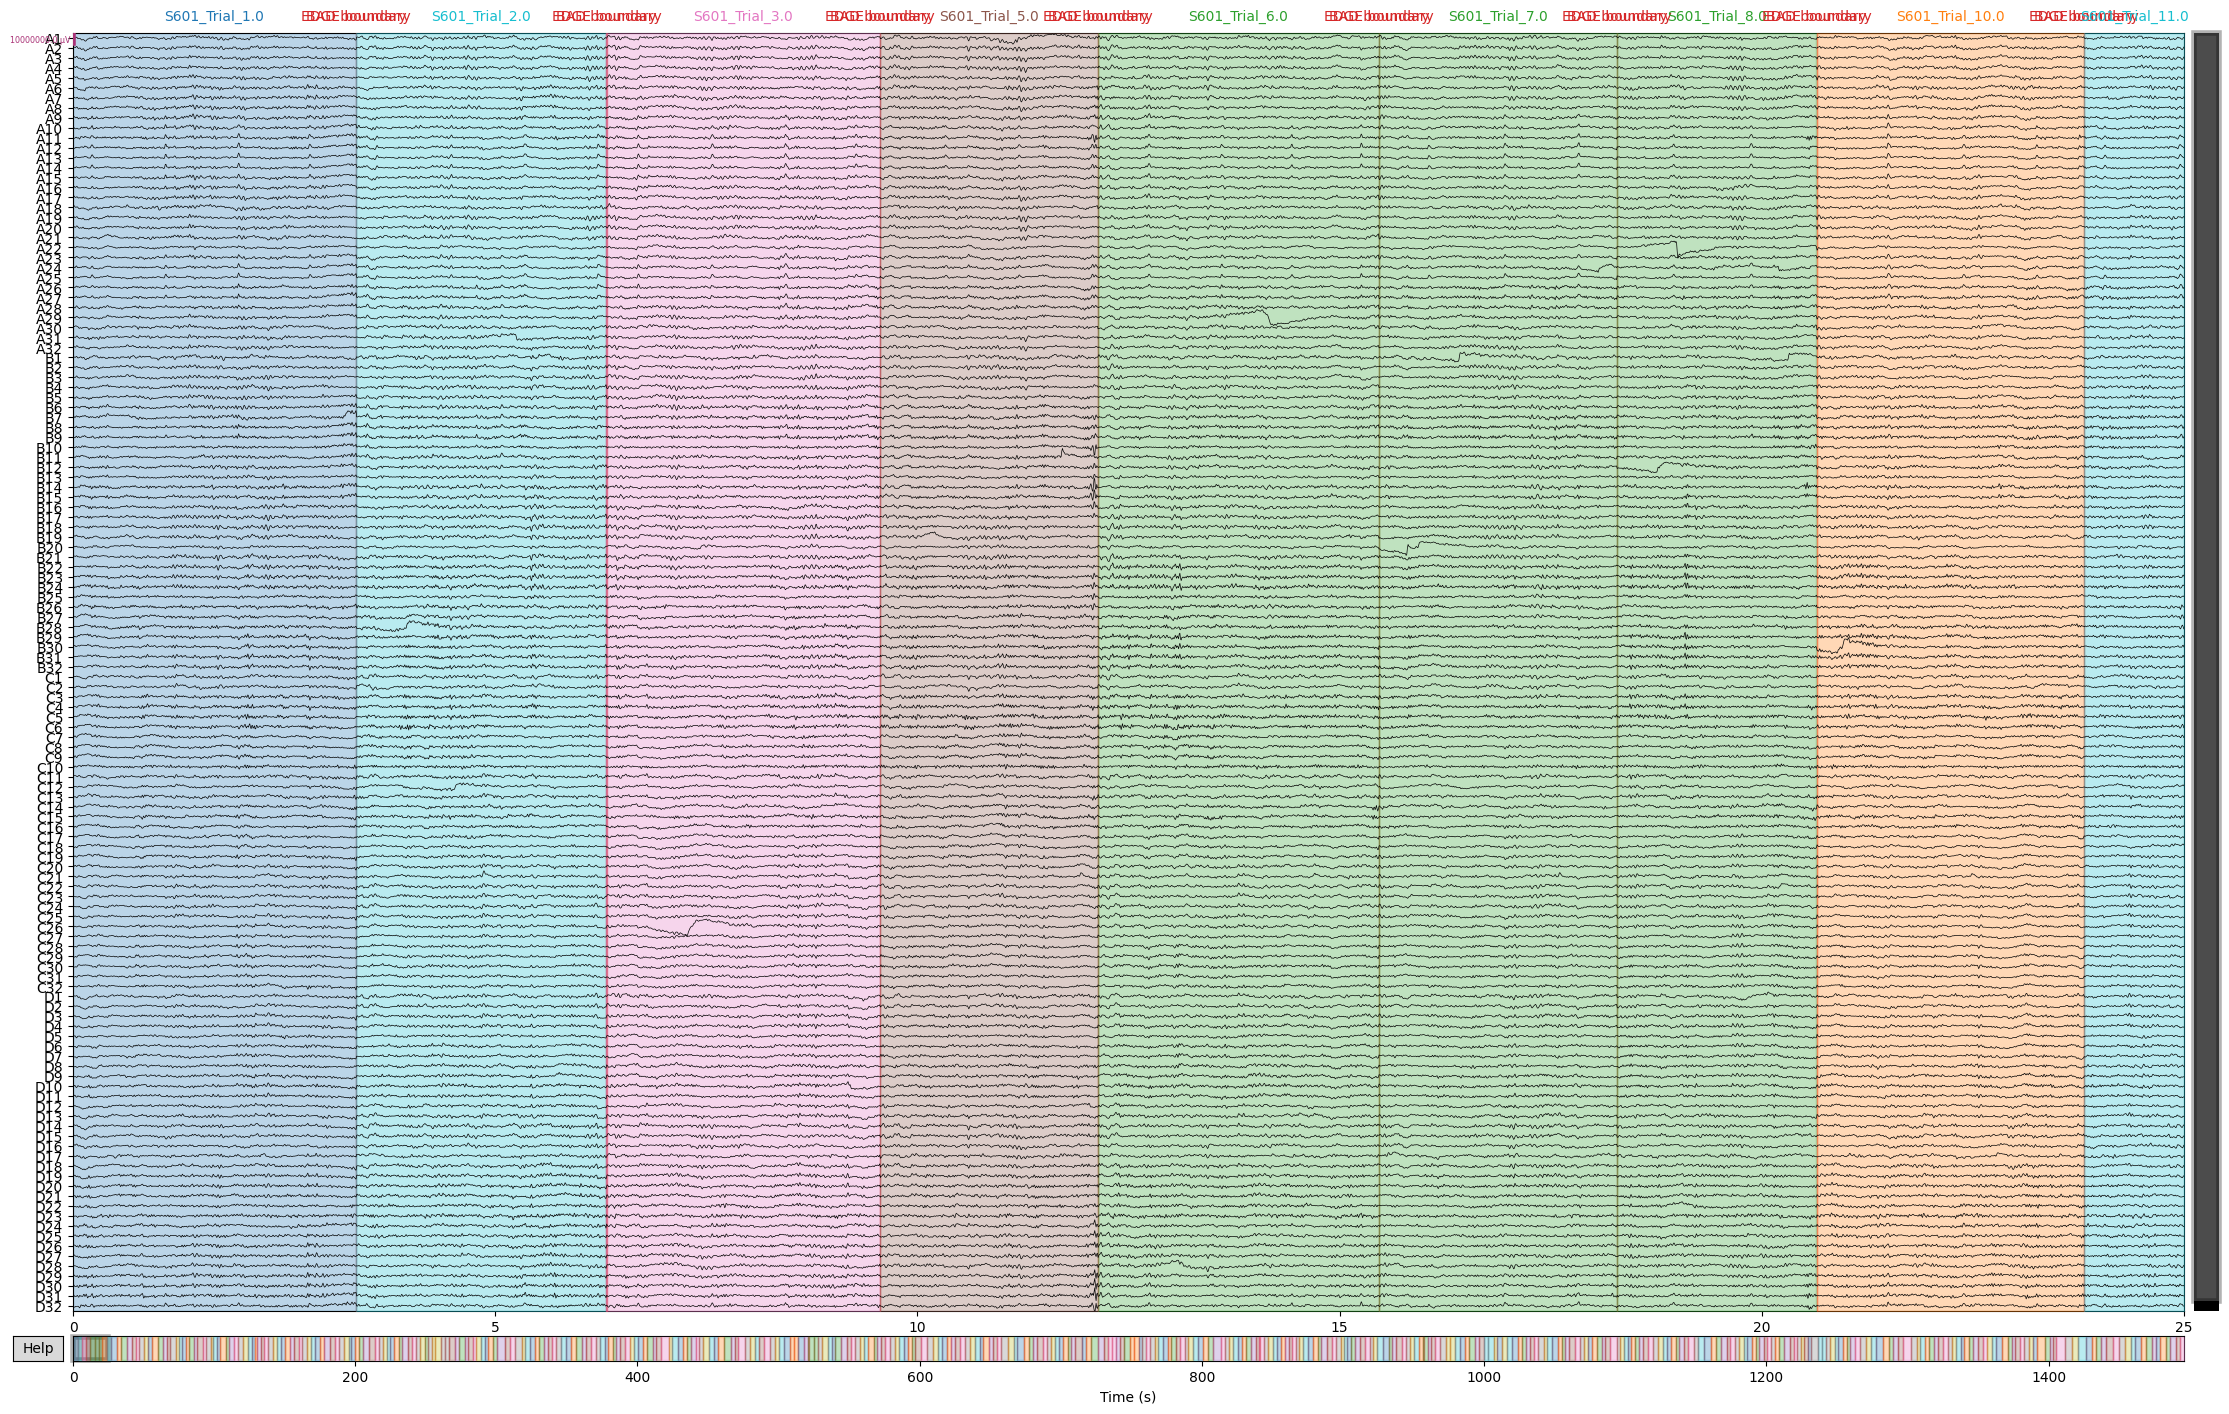

Channels marked as bad:
none


In [2]:
combined_pregICA_path = os.path.join(workspace_root, 'Data', 'combined_pregICA.fif')
combined_pregICA = mne.io.read_raw_fif(combined_pregICA_path, preload=True)
%matplotlib qt
combined_pregICA.plot(duration=25, n_channels=128, scalings= 5 )